In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as spo
% matplotlib inline

# get input datas
def get_stock_data(symbol):
    df = pd.read_csv('yahoo/20160922/{}.csv'.format(symbol), index_col='Date', parse_dates=True,
                     usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'],
                     na_values=['nan'])
    df.dropna()
    return df

def draw_rolling_statistics(df, symbol, window):
    rolling_mean = df[symbol].rolling(window=window).mean()
    rolling_std = df[symbol].rolling(window=window).std()
    bollinger_band_upper = rolling_mean + 2 * rolling_std
    bollinger_band_lower = rolling_mean - 2 * rolling_std
    plot = df[symbol].plot(title='{} rolling mean'.format(symbol), label='price')
    rolling_mean.plot(label='rolling mean', ax=plot)
    bollinger_band_upper.plot(label='upper band', ax=plot)
    bollinger_band_lower.plot(label='lower band', ax=plot)
    plot.set_xlabel("Date")
    plot.set_ylabel("Price")
    plot.legend(loc='upper left')
    plt.show()

def draw_scatter_plot(daily_returns, x_symbol, y_symbol):
    daily_returns.plot(kind='scatter', x=x_symbol, y=y_symbol, title='{} vs {} Daily return Scatter plot'.format(x_symbol, y_symbol))
    beta, alpha=np.polyfit(daily_returns[x_symbol], daily_returns[y_symbol], 1)
    plt.plot(daily_returns[x_symbol], beta * daily_returns[x_symbol] + alpha, '-', color='r')
    plt.show()

def draw_value_of_future_dollor(label, future_value, IR):
    time_years = np.linspace(0, 10, 21)
    present_value = future_value / (1 + IR) ** time_years
    plt.plot(time_years, present_value, linewidth=2.0, label=label)
    
def calculate_daily_returns(df):
    daily_returns=df.copy()
    daily_returns=(daily_returns/daily_returns.shift(1))-1
    return daily_returns[1:]

def calculate_cumulative_returns(df):
    return (df/df.ix[0]) - 1

def calculate_porfolio_value(df, start_val, symbols, allocs):
    portfolio_close_df=df[symbols]
    normalized_df=portfolio_close_df/portfolio_close_df.ix[0,:]
    alloced_df=normalized_df * allocs
    position_vals_df=alloced_df * start_val
    portfolio_val_df=position_vals_df.sum(axis=1)
    return portfolio_val_df

def calculate_intrinsic_value(dividends_per_year, discount_rate):
    return dividends_per_year / discount_rate

def calculate_book_value(total_assets, intangible_assets, liabilities):
    return total_assets - intangible_assets - liabilities

def calculate_market_capitalization(number_of_shares, price_per_share):
    return number_of_shares * price_per_share

def calculate_capm_stock_return(market_return, stock_alpha, stock_beta):
    if stock_alpha < 0:
        return -(stock_beta * market_return + stock_alpha)
    return stock_beta * market_return + stock_alpha

def calculate_capm_portfolio_return(market_return, allocs, alphas, betas):
    return (allocs * betas * market_return + allocs * alphas).sum()

def error(allocs, betas):
    for alloc in allocs:
        if alloc >= 1:
            return 1000000

    err = abs(allocs[0] * betas[0] + allocs[1] * betas[1]) + abs(sum(abs(allocs)) - 1)
    return err

def fit_line(betas, error_func):
    allocs = np.float32([.9, .1])
    result = spo.minimize(error_func, allocs, args=(betas,), method="SLSQP", options={'disp': True, 'maxiter': 1000})
    return result.x

def calculate_capm_weights_from_betas(betas):
    l_fit = fit_line(betas, error)
    print "Fitted line:C0={}, C1={}".format(l_fit[0], l_fit[1])

def calculate_momentum(df, n):
    df=df/df.shift(n)
    return df[n:] - 1

def calculate_sma(df, n):
    return (df/df.rolling(window=n,center=False).mean())[n:] - 1

def calculate_bb(df, n):
    std=(df.rolling(window=n,center=False).std())[n:]
    ma=(df.rolling(window=n,center=False).mean())[n:]
    upper_bound=ma+2*std
    lower_bound=ma-2*std
    return upper_bound, lower_bound

def normalize(df):
    return (df - df.mean())/df.std()

In [2]:
stocks = {}
symbols = ['GOOGL']
for symbol in symbols:
    stocks[symbol] = get_stock_data(symbol)
    

start_date = '2016-01-01'
end_date = '2016-05-31'
dates = pd.date_range(start_date, end_date)

adj_close_df = pd.DataFrame(index=dates)
for stock_name in stocks:
    stock = stocks[stock_name]
    temp_df = stock[['Adj Close']].rename(columns={'Adj Close': stock_name})
    adj_close_df = adj_close_df.join(temp_df)

adj_close_df.fillna(method='ffill', inplace='TRUE')
adj_close_df.fillna(method='bfill', inplace='TRUE')
adj_close_df.dropna()

print ""

In [410]:
class Stock(object):
    def __init__(self, symbol=None, stocks={}
                 , start_date=None, end_date=None
                 , momentum_window=3, sma_window=3, bollinger_bands_window=3):
        
        self.max_window=max(momentum_window, sma_window, bollinger_bands_window)
        dates = pd.date_range(start_date, end_date)

        adj_close_df = pd.DataFrame(index=dates)
        stock = stocks[symbol]
        temp_df = stock[['Adj Close']]
        adj_close_df = adj_close_df.join(temp_df)

        adj_close_df.fillna(method='ffill', inplace='TRUE')
        adj_close_df.fillna(method='bfill', inplace='TRUE')
        adj_close_df.dropna()
        
        self.original_df=adj_close_df
        self.df=adj_close_df
        self.momentum_window=momentum_window
        self.sma_window=sma_window
        self.bollinger_bands_window=bollinger_bands_window
        
        self.df=self.df.join(self._calculate_daily_returns())
        self.df=self.df.join(self._calculate_cumulative_returns())
        self.df=self.df.join(self._calculate_momentum())
        self.df=self.df.join(self._calculate_sma())
        bb_upper_bound,bb_lower_bound=self._calculate_bb()
        self.df=self.df.join(bb_upper_bound)
        self.df=self.df.join(bb_lower_bound)
        
        self.source_df=self.df.copy()
        
# #         self.df=self.df.join(self.source_df.shift(1), rsuffix="[1 day before]")
# #         self.df=self.df.join(self.source_df.shift(2), rsuffix="[2 day before]")
# #         self.df=self.df.join(self.source_df.shift(3), rsuffix="[3 day before]")
# #         self.df=self.df.join(self.source_df.shift(4), rsuffix="[4 day before]")
# #         self.df=self.df.join(self.source_df.shift(5), rsuffix="[5 day before]")
#         for i in range(28,35):
#             self.df=self.df.join(self.source_df.shift(i), rsuffix="[{} day before]".format(i))
        
#         self.df=self.df.drop('Daily Returns', axis=1)
#         self.df=self.df.drop('Cumulative Returns', axis=1)
#         self.df=self.df.drop('Momentum', axis=1)
#         self.df=self.df.drop('SMA', axis=1)
#         self.df=self.df.drop('BB Upper Bound', axis=1)
#         self.df=self.df.drop('BB Lower Bound', axis=1)
        
#         self.df.fillna(method='ffill', inplace='TRUE')
#         self.df.fillna(method='bfill', inplace='TRUE')
#         self.df.dropna()
        
#         self.df=self.df[self.max_window:]
        
        pass
    
    def get_df_for_prediction(self, n=1):
        df = self.source_df.copy()
        source_df = self.source_df.copy()
        for i in range(n,n+7):
            df=df.join(source_df.shift(i), rsuffix="[{} day before]".format(i))
        
        df=df.drop('Daily Returns', axis=1)
        df=df.drop('Cumulative Returns', axis=1)
        df=df.drop('Momentum', axis=1)
        df=df.drop('SMA', axis=1)
        df=df.drop('BB Upper Bound', axis=1)
        df=df.drop('BB Lower Bound', axis=1)
        
        df.fillna(method='ffill', inplace='TRUE')
        df.fillna(method='bfill', inplace='TRUE')
        df.dropna()
        
        return df[self.max_window:]
    
    def print_df(self):
        print self.df
    
    def _calculate_daily_returns(self):
        df=self.original_df
        daily_returns=df.copy()
        daily_returns=(daily_returns/daily_returns.shift(1))-1
        return daily_returns[1:].rename(columns={'Adj Close': 'Daily Returns'})
    
    def _calculate_cumulative_returns(self):
        df=self.original_df
        return ((df/df.ix[0]) - 1).rename(columns={'Adj Close': 'Cumulative Returns'})

    def _calculate_momentum(self):
        df=self.original_df
        n=self.momentum_window
        
        df=df/df.shift(n)
        return (df[n:] - 1).rename(columns={'Adj Close': 'Momentum'})

    def _calculate_sma(self):
        df=self.original_df
        n=self.sma_window
        
        return ((df/df.rolling(window=n,center=False).mean())[n:] - 1).rename(columns={'Adj Close': 'SMA'})

    def _calculate_bb(self):
        df=self.original_df
        n=self.bollinger_bands_window
        
        std=(df.rolling(window=n,center=False).std())[n:]
        ma=(df.rolling(window=n,center=False).mean())[n:]
        upper_bound=ma+2*std
        lower_bound=ma-2*std
        return upper_bound.rename(columns={'Adj Close': 'BB Upper Bound'}), lower_bound.rename(columns={'Adj Close': 'BB Lower Bound'})

    def normalize(self):
        df=self.df
        return (df - df.mean())/df.std()
    

def print_result(name, y_test, y_pred):
    y_test_out = y_test.reset_index().drop("index", axis=1)
    
    print "{} Error : {}%".format(name, sum(abs((y_test_out['Adj Close'] - y_pred) / y_test_out['Adj Close'])) * 100 / len(y_test_out))
    y_test_out['pred']=y_pred
    y_test_out.plot()
    
google=Stock(symbol='GOOGL',stocks=stocks
                , start_date='2014-02-01', end_date='2016-05-31'
                , momentum_window=3, sma_window=3, bollinger_bands_window=3)

# use Random Forest
from sklearn import cross_validation

X=google.get_df_for_prediction(1).drop("Adj Close", axis=1).reset_index().drop("index", axis=1).astype(int)
y=google.original_df[google.max_window:].reset_index().drop("index", axis=1).astype(int)

X_train, X_test=X[:int(len(X) * 0.8)], X[int(len(X) * 0.8):]
y_train, y_test=y[:int(len(y) * 0.8)], y[int(len(y) * 0.8):]
#X_train, X_test, y_train, y_test=cross_validation.train_test_split(X,y, test_size=0.3, random_state=0)

Logistic Regression Error : 18.5656217363%


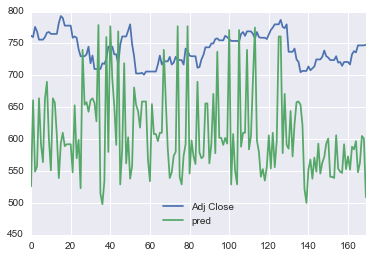

In [411]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train["Adj Close"])
y_pred = logreg.predict(X_test)
print_result("Logistic Regression", y_test, y_pred)

Ridge Error : 0.871224401854%


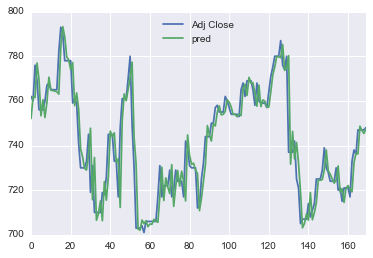

In [412]:
# Ridge
from sklearn import linear_model
ridge = linear_model.Ridge (alpha = .5)
ridge.fit(X_train, y_train["Adj Close"])
y_pred = ridge.predict(X_test)
print_result("Ridge", y_test, y_pred)

Lasso Error : 0.871537835778%


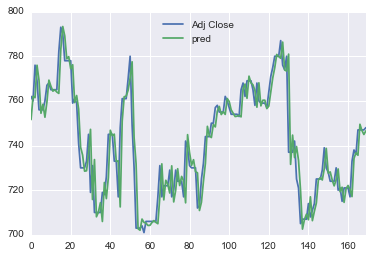

In [413]:
# Lasso
from sklearn import linear_model
lasso = linear_model.Lasso(alpha = 0.1)
lasso.fit(X_train, y_train["Adj Close"])
y_pred = lasso.predict(X_test)
print_result("Lasso", y_test, y_pred)

Lasso LARS Error : 1.22737643689%


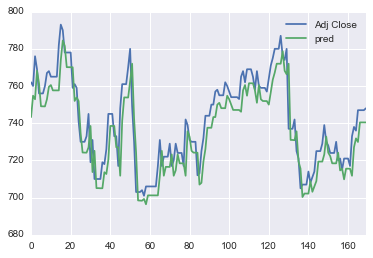

In [414]:
# Lasso LARS
from sklearn import linear_model
lasso_lars = linear_model.LassoLars(alpha = 0.1)
lasso_lars.fit(X_train, y_train["Adj Close"])
y_pred = lasso_lars.predict(X_test)
print_result("Lasso LARS", y_test, y_pred)

Bayesian Ridge Error : 0.85952537466%


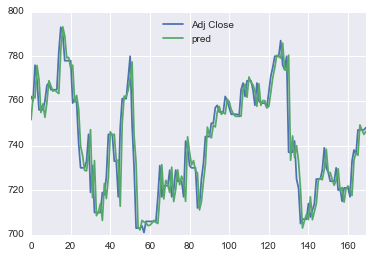

In [415]:
# Bayesian Ridge
from sklearn import linear_model
bayesian_ridge = linear_model.BayesianRidge()
bayesian_ridge.fit(X_train, y_train["Adj Close"])
y_pred = bayesian_ridge.predict(X_test)
print_result("Bayesian Ridge", y_test, y_pred)

Decision Tree Regression Error : 1.72487005082%


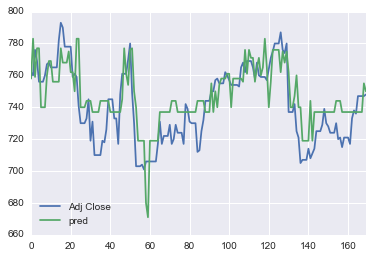

In [416]:
# Decision Tree Regression
from sklearn import tree
decision_tree = tree.DecisionTreeRegressor()
decision_tree.fit(X_train, y_train["Adj Close"])
y_pred = decision_tree.predict(X_test)
print_result("Decision Tree Regression", y_test, y_pred)

Random Forests Error : 2.08634424978%


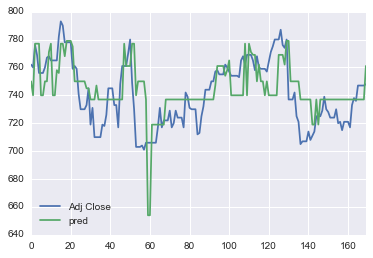

In [417]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train["Adj Close"])
y_pred=random_forest.predict(X_test)
print_result("Random Forests", y_test, y_pred)

Support Vector Machine Regression Error : 23.4246941581%


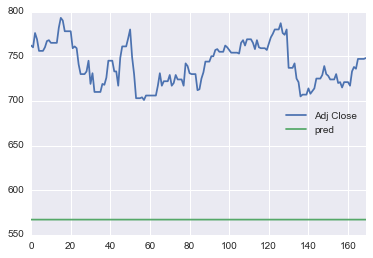

In [418]:
# Support Vector Machines
from sklearn import svm
from sklearn.svm import SVC, LinearSVC

svr = svm.SVR()
svr.fit(X_train, y_train["Adj Close"])
y_pred = svr.predict(X_test)
print_result("Support Vector Machine Regression", y_test, y_pred)

KNN Error : 2.43867232873%


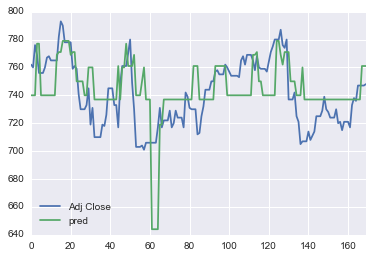

In [419]:
from sklearn.neighbors import KNeighborsClassifier

# KNN
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train["Adj Close"])
y_pred = knn.predict(X_test)
print_result("KNN", y_test, y_pred)

Gaussian Naive Bayes Error : 3.6975961455%


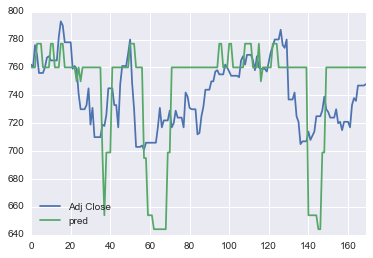

In [420]:
from sklearn.naive_bayes import GaussianNB

# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, y_train["Adj Close"])
y_pred = gaussian.predict(X_test)
print_result("Gaussian Naive Bayes", y_test, y_pred)

Ada Boost Error : 23.3644993783%


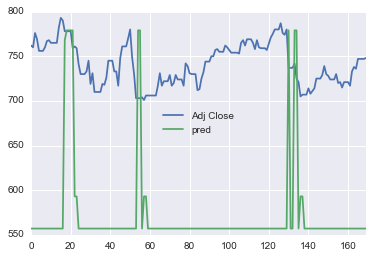

In [421]:
from sklearn.ensemble import AdaBoostClassifier

adaboost=AdaBoostClassifier(n_estimators=100)
adaboost.fit(X_train, y_train["Adj Close"])
y_pred = adaboost.predict(X_test)
print_result("Ada Boost", y_test, y_pred)

Gradient Boost Error : 1.4203431289%


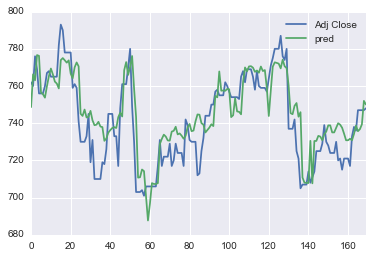

In [422]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boost=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=6, random_state=0, loss='ls')
gradient_boost.fit(X_train, y_train["Adj Close"])
y_pred = gradient_boost.predict(X_test)
print_result("Gradient Boost", y_test, y_pred)

In [423]:
def predict_future_values(stock_data, regressor, start_day, end_day, predict_day):
    # TODO get historical data from start_day + end_day
    # TODO train 1 day regressor by start_day~end_day
    # TODO train 2 day regressor by start_day~end_day
    # ...
    # TODO predict from end_day+1 by 1 day regressor
    # TODO predict from end_day+2 by 2 day regressor
    # ...
    print "TODO impl!"    
    
# TODO calculate & display error. per day + total.